In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import os
from time import time

In [2]:
porter = PorterStemmer()
stop = stopwords.words('english')

#공백으로 단어 분리
def tokenizer(text):
    return text.split()

# Porter Stemming 알고리즘을 이용해 단어 분리
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

github_path = 'C:/Users/taehee/Documents/GitHub/tripReviewAnalysisSystem/'

#engine='python' 을 넣어줘야 판다스가 한국어로 된 폴더명을 인식한다.
df = pd.read_csv(github_path +'크롤러-전처리/원시자료/Jongmyo Shrine.txt', encoding = 'utf-8', engine='python', index_col = 0)
df.columns

Index(['star_point', 'title', 'text', 'Date of experience'], dtype='object')

In [3]:
s1 = pd.Series(dtype=int)
df['sentiment'] = s1
df['sentiment'] = np.where(df.star_point > 3, '1', '0')

df.head()

,star_point,title,text,Date of experience,sentiment
0,5.0,Peaceful and Insightful in the Middle of A Met...,Really this is one of the few places I enjoyed...,January 2020,1
1,3.0,Spiritual,"Guided tours in English, German, Chinese and J...",April 2019,0
2,4.0,Informative tour,Jongmyo shrine is a fascinating visit for anyo...,November 2019,1
3,3.0,Good for a relaxing walk in the park and some ...,Entry to the Jongmyo Shrine is included in the...,September 2019,0
4,4.0,Shrine for the spirits of kings,I just thought of going there as it was near G...,October 2019,1


In [4]:
len(df)

195

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

In [6]:
def model_tfidf(df, train_size, c_value):
    '''
    입력 : text와 sentiment가 포함된 리뷰들의 데이터 프레임
    출력 : 훈련이 끝난 분류기와 정확도를 리턴.
    '''
    
    data_train_size = int(len(df) * float(train_size))
    print('데이터 개수 : ' + str(data_train_size))

    X_train = df.loc[:data_train_size, 'text'].values
    y_train = df.loc[:data_train_size, 'sentiment'].values #긍.부정
    X_test = df.loc[data_train_size: ,'text'].values
    y_test = df.loc[data_train_size: , 'sentiment'].values
    tfidf = TfidfVectorizer(lowercase=False, tokenizer=tokenizer)
    Ir_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression(C=c_value ,penalty='l2', random_state=0, solver='lbfgs'))])

    stime=time()
    Ir_tfidf.fit(X_train, y_train)

    y_pred = Ir_tfidf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print('정확도: %.3f' %test_accuracy)
    
    return Ir_tfidf, test_accuracy

In [7]:
#리뷰 리스트 불러오기기
file_list = os.listdir(github_path + '크롤러-전처리/원시자료/')

print ("file_list: {}".format(file_list[:10]))

file_list: ['63 City.txt', 'Alive Museum Insadong.txt', 'Amore Pacific Museum of Art.txt', 'An Jung-geun Memorial Hall.txt', 'Ansan Jarak-gil.txt', 'apm Place.txt', 'Arario Museum in Space.txt', "Baek In-je's House.txt", 'Banpodaegyo Bridge.txt', 'Bongeunsa Temple.txt']


In [8]:
result = pd.read_csv(github_path + '크롤러-전처리/원시자료/' + file_list[0], encoding = 'utf-8', engine='python')
result.head()

,Unnamed: 0,star_point,title,text,Date of experience
0,0,3.0,nothing special,just a tall building in a residential area. no...,February 2020
1,1,4.0,City Views,"Had lunch on 59th floor, outstanding views of ...",October 2019
2,2,3.0,Great Views,Stopped by here as it was along my travel plan...,April 2019
3,3,3.0,Just a tall building,I don't know what I was expecting but this was...,August 2018
4,4,3.0,63 City,Took a 10-15 mins walk from the Yeoinaru stati...,July 2019


In [9]:
def all_reviews(github_path, file_list ,size):
    result = pd.read_csv(github_path + '크롤러-전처리/원시자료/' + file_list[0], encoding = 'utf-8', engine='python', index_col = 0)
    stime=time()
    print('데이터 로딩 start')

    for file_path in file_list[:size]:
        new_data = pd.read_csv(github_path + '크롤러-전처리/원시자료/' + file_path, encoding = 'utf-8', engine='python', index_col = 0)
        # 새 데이터를 리스트로 합쳐서 concat시키면 행이 계속 추가 된다.
        # ignore_index로 기존 인덱스를  무시하고 합친 결과를 다시 인덱스해준다. 이거 안 하면 index must be monotonic increasing or decreasing 에러가 뜰 것이다.
        result = pd.concat([result, new_data], ignore_index = True, sort = False)
    
    print('데이터 로딩 종료: 소요시간 [%d]초' %(time()-stime))
    
    result['sentiment'] = s1
    result['sentiment'] = np.where(result.star_point > 3, '1', '0')
        
    return result

In [10]:
data_30 = all_reviews(github_path, file_list, 30)
model_30_c30 = model_tfidf(data_30, train_size= 0.7, c_value = 30.0)

데이터 로딩 start
데이터 로딩 종료: 소요시간 [0]초
데이터 개수 : 1535
정확도: 0.777


In [11]:
model_30_c10 = model_tfidf(data_30, train_size= 0.7, c_value = 10.0)

데이터 개수 : 1535
정확도: 0.774


In [12]:
data_100 = all_reviews(github_path, file_list, 100)
model_100 = model_tfidf(data_100, train_size= 0.7, c_value = 10.0)

데이터 로딩 start
데이터 로딩 종료: 소요시간 [3]초
데이터 개수 : 5426
정확도: 0.822


C:\Users\taehee\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [13]:
data_all = all_reviews(github_path, file_list, len(file_list))

데이터 로딩 start
데이터 로딩 종료: 소요시간 [13]초


In [14]:
models = []
for c_test_value in [100.0, 10.0, 1, 0.1]:
    print('c값 : ' + str(c_test_value))
    models.append([c_test_value, model_tfidf(data_100, train_size= 0.7, c_value = c_test_value)[1]])

c값 : 100.0
데이터 개수 : 5426


C:\Users\taehee\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


정확도: 0.808
c값 : 10.0
데이터 개수 : 5426


C:\Users\taehee\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


정확도: 0.822
c값 : 1
데이터 개수 : 5426
정확도: 0.822
c값 : 0.1
데이터 개수 : 5426
정확도: 0.821


In [15]:
result_models_test = pd.DataFrame(models, columns = ['cvalue','accuracy'])
result_models_test

,cvalue,accuracy
0,100.0,0.808255
1,10.0,0.822442
2,1.0,0.821582
3,0.1,0.820722


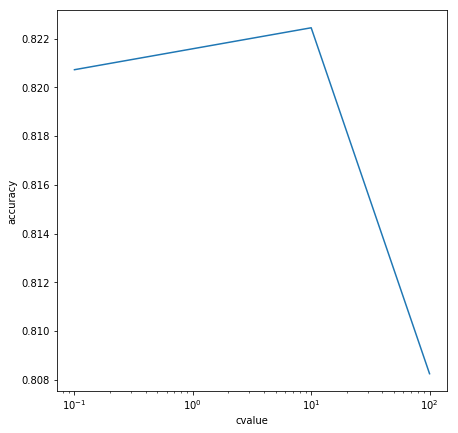

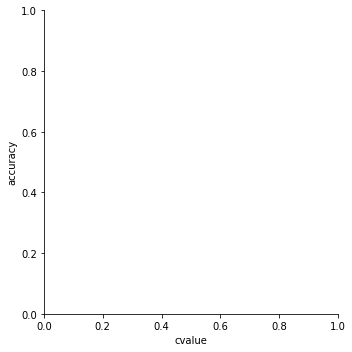

In [16]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
sns.relplot(x="cvalue", y="accuracy", kind="line", data=result_models_test, ax=ax)
plt.show()

In [17]:
#머신러닝 결과 파일로 저장(머신러닝 알고리즘을 계속 불러오지 않기 위하여)
curDir=os.getcwd()
dest = os.path.join(curDir, 'data', 'pklObject')
if not os.path.exists(dest):
    os.makedirs(dest)

path_save = os.path.join(dest, 'classifier.pkl')
pickle.dump(models[2], open(path_save, 'wb'), protocol=4)
print(path_save + '분류기 머신러닝 모델 저장 완료')

C:\Users\taehee\Documents\GitHub\tripReviewAnalysisSystem\머신-딥러닝\data\pklObject\classifier.pkl분류기 머신러닝 모델 저장 완료
